In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from os.path import join

import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, LeakyReLU, Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


**Implementation of MNIST Data Loader**

In [5]:
import numpy as np

class MnistDataloader:
    def __init__(self, train_images_path, train_labels_path, test_images_path, test_labels_path):
        self.train_images_path = train_images_path
        self.train_labels_path = train_labels_path
        self.test_images_path = test_images_path
        self.test_labels_path = test_labels_path

    def load_images(self, file_path):
        with open(file_path, 'rb') as f:
            f.read(16)  # Skip the magic number and dimensions info
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)

    def load_labels(self, file_path):
        with open(file_path, 'rb') as f:
            f.read(8)  # Skip the magic number and number of labels
            labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

    def load_data(self):
        x_train = self.load_images(self.train_images_path)
        y_train = self.load_labels(self.train_labels_path)
        x_test = self.load_images(self.test_images_path)
        y_test = self.load_labels(self.test_labels_path)
        return (x_train, y_train), (x_test, y_test)


**Dataset Loading: Using Your Four-Files Format**

In [6]:
# Assuming your MnistDataloader class is already defined elsewhere in your notebook.

input_path = '../input'  # Change this if your folder is somewhere else!
training_images_filepath = join(input_path, r"C:\Users\demia\Downloads\train-images-idx3-ubyte\train-images-idx3-ubyte")
training_labels_filepath = join(input_path, r"C:\Users\demia\Downloads\train-labels-idx1-ubyte\train-labels-idx1-ubyte")
test_images_filepath = join(input_path, r"C:\Users\demia\Downloads\t10k-images-idx3-ubyte\t10k-images-idx3-ubyte")
test_labels_filepath = join(input_path, r"C:\Users\demia\Downloads\t10k-labels-idx1-ubyte\t10k-labels-idx1-ubyte")

mnist_dataloader = MnistDataloader(
    training_images_filepath, training_labels_filepath,
    test_images_filepath, test_labels_filepath
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Normalize pixel values to [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = x_train[..., None] if x_train.ndim == 3 else x_train  # Ensure (N, 28, 28, 1)

print(f"Training data shape: {x_train.shape}")  # Should show (N, 28, 28, 1)


Training data shape: (60000, 28, 28, 1)


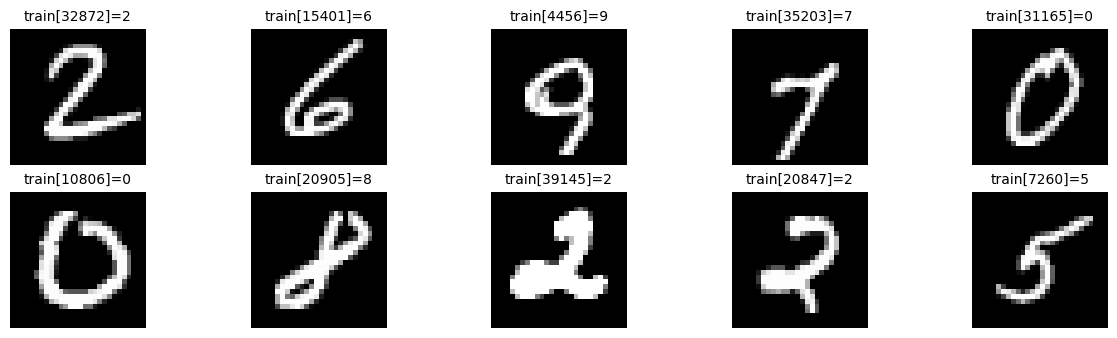

In [7]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(15,6))
    index = 1    
    for img, title_text in zip(images, title_texts):        
        plt.subplot(rows, cols, index)        
        plt.imshow(img.squeeze(), cmap='gray')
        if title_text:
            plt.title(title_text, fontsize=10)
        plt.axis('off')
        index += 1

images_2_show, titles_2_show = [], []
for i in range(10):
    r = random.randint(0, x_train.shape[0]-1)
    images_2_show.append(x_train[r])
    titles_2_show.append(f"train[{r}]={y_train[r]}")

show_images(images_2_show, titles_2_show)


**Define the Generator Model**

In [9]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(7 * 7 * 256, input_dim=latent_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(1, kernel_size=7, activation='tanh', padding='same'))
    return model

latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │         3,137 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,926,401 (7.35 MB)

 Trainable params: 1,926,017 (7.35 MB)

 Non-trainable params: 384 (1.50 KB)

**Define the Discriminator Model**

In [10]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.summary()


c:\Users\demia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,769 (315.50 KB)

 Trainable params: 80,769 (315.50 KB)

 Non-trainable params: 0 (0.00 B)

**Compile the Models**

In [11]:
optimizer = Adam(0.0002, 0.5)

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False

# Combined DCGAN (generator + frozen discriminator)
z = Input(shape=(latent_dim,))
generated_img = generator(z)
validity = discriminator(generated_img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


c:\Users\demia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0 [D loss: 0.6950, acc.: 44.14%] [G loss: 0.6824]


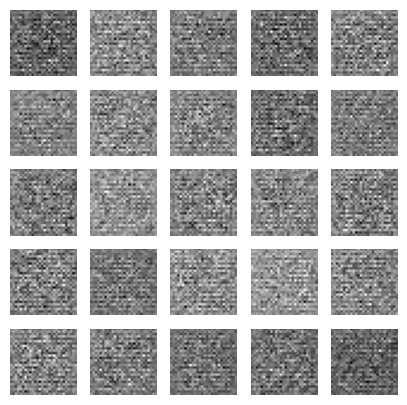

Epoch 1000 [D loss: 1.1545, acc.: 29.21%] [G loss: 0.1853]


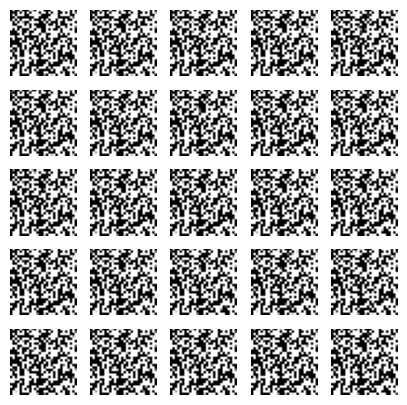

Epoch 2000 [D loss: 1.2348, acc.: 29.17%] [G loss: 0.1701]


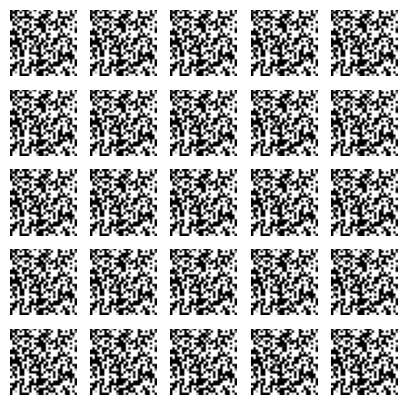

Epoch 3000 [D loss: 1.2624, acc.: 29.19%] [G loss: 0.1648]


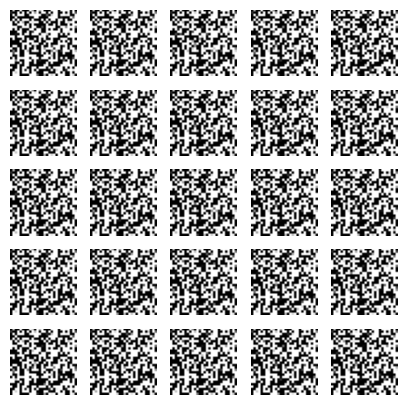

Epoch 4000 [D loss: 1.2770, acc.: 29.16%] [G loss: 0.1618]


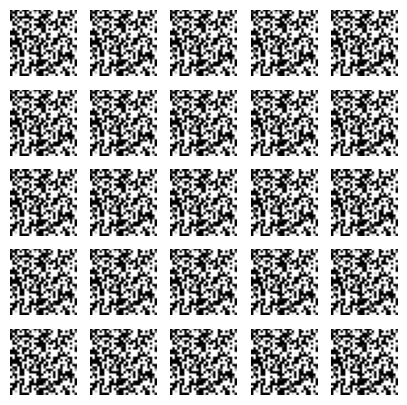

Epoch 5000 [D loss: 1.2862, acc.: 29.13%] [G loss: 0.1599]


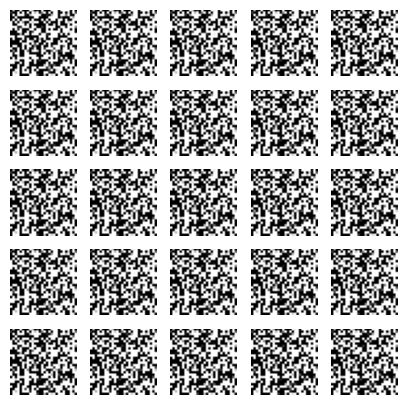

Epoch 6000 [D loss: 1.2925, acc.: 29.13%] [G loss: 0.1586]


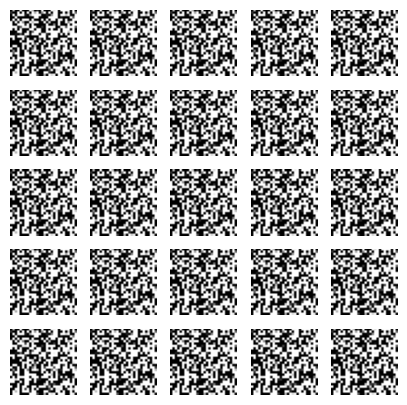

Epoch 7000 [D loss: 1.2971, acc.: 29.13%] [G loss: 0.1576]


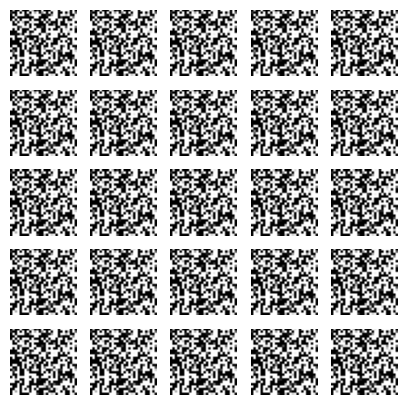

Epoch 8000 [D loss: 1.3006, acc.: 29.11%] [G loss: 0.1568]


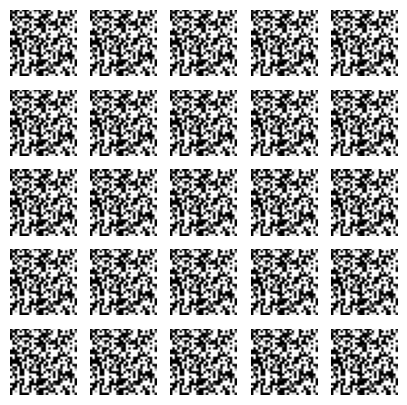

Epoch 9000 [D loss: 1.3033, acc.: 29.11%] [G loss: 0.1562]


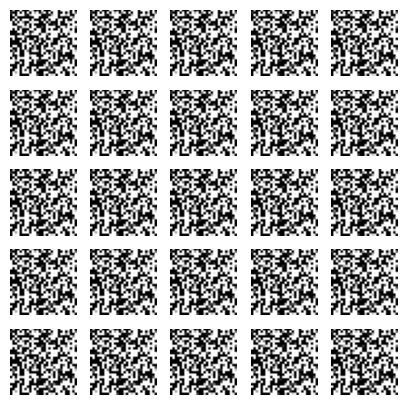

In [12]:
import os

batch_size = 64
epochs = 10000
sample_interval = 1000

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    #  Train Discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_imgs = generator.predict(noise, verbose=0)
    
    d_loss_real = discriminator.train_on_batch(real_imgs, real)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    #  Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, real)
    
    #  Print progress and sample images
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        # Generate a batch of images to visualize
        gen_imgs = generator.predict(np.random.normal(0, 1, (25, latent_dim)), verbose=0)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0,1]
        fig, axs = plt.subplots(5, 5, figsize=(5, 5))
        count = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                count += 1
        plt.show()
